In [35]:
import sys
sys.getfilesystemencoding()

'utf-8'

In [5]:
from os import walk
from os.path import join

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import nltk
from nltk.stem import PorterStemmer, SnowballStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from bs4 import BeautifulSoup
from wordcloud import WordCloud
from PIL import Image

from sklearn.model_selection import train_test_split

%matplotlib inline

In [7]:
SPAM_1_PATH = 'SpamData/01_Processing/spam_assassin_corpus/spam_1'
SPAM_2_PATH = 'SpamData/01_Processing/spam_assassin_corpus/spam_2'
EASY_NONSPAM_1_PATH = 'SpamData/01_Processing/spam_assassin_corpus/easy_ham_1'
EASY_NONSPAM_2_PATH = 'SpamData/01_Processing/spam_assassin_corpus/easy_ham_2'

SPAM_CAT= 1
HAM_CAT = 0
VOCAB_SIZE = 2500

DATA_JSON_FILE='SpamData/01_Processing/email-text-data.json'
WORD_ID_FILE='SpamData/01_Processing/word-by-id.csv'

TRAINING_DATA_FILE = 'SpamData/02_Training/train-data.txt'
TEST_DATA_FILE = 'SpamData/02_Training/test-data.txt'

WHALE_FILE= 'SpamData/01_Processing/wordcloud_resources/whale-icon.png'
SKULL_FILE= 'SpamData/01_Processing/wordcloud_resources/skull-icon.png'
THUMBS_UP_FILE= 'SpamData/01_Processing/wordcloud_resources/thumbs-up.png'
THUMBS_DOWN_FILE= 'SpamData/01_Processing/wordcloud_resources/thumbs-down.png'

CUSTOM_FONT_FILE= 'SpamData/01_Processing/wordcloud_resources/OpenSansCondensed-Bold.ttf'

In [6]:
def email_body_generator(path):
    """
    Generator function that opens a txt file and extracts the body of the email
    Returns the file name and the email body as a string
    """
    for root, dirnames, filenames in walk(path):
        for file_name in filenames:
            filepath = join(root, file_name)
            stream = open(filepath, encoding='latin-1')
            is_body = False
            lines = []
            for line in stream:
                if is_body:
                    lines.append(line)
                elif line == '\n':
                    is_body = True
            stream.close()

            email_body = '\n'.join(lines)
            yield file_name, email_body


def df_from_directory(path, classification):
    """
    Function that opens all the text files in a directory 
    and returns a data frame with the message and the classification
    """
    rows = []
    row_names = []

    for file_name, email_body in email_body_generator(path):
        rows.append({'MESSAGE': email_body, 'CATEGORY': classification})
        row_names.append(file_name)

    return pd.DataFrame(rows, index=row_names)

## Generator Functions

In [8]:
spam_emails= df_from_directory(SPAM_1_PATH,SPAM_CAT)
spam_emails= spam_emails.append(df_from_directory(SPAM_2_PATH,SPAM_CAT))

ham_emails= df_from_directory(EASY_NONSPAM_1_PATH,HAM_CAT)
ham_emails= ham_emails.append(df_from_directory(EASY_NONSPAM_2_PATH,HAM_CAT))

C:\Users\Diana C Contreras\AppData\Local\Temp\ipykernel_3720\3058826588.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spam_emails= spam_emails.append(df_from_directory(SPAM_2_PATH,SPAM_CAT))
C:\Users\Diana C Contreras\AppData\Local\Temp\ipykernel_3720\3058826588.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ham_emails= ham_emails.append(df_from_directory(EASY_NONSPAM_2_PATH,HAM_CAT))


In [36]:
spam_emails.shape
ham_emails.shape

(3901, 2)

In [10]:
data= pd.concat([spam_emails, ham_emails])
print('Shape of entire dataframe is ', data.shape)

Shape of entire dataframe is  (5799, 2)


## Data Cleaning: Cheching for Missing Values

In [11]:
data['MESSAGE'].isnull().values.any()
data.MESSAGE.isnull().sum()

0

In [12]:
#Check if there are empty emails (string length zero)
data[data.MESSAGE.str.len()==0].index

Index(['cmds', 'cmds', 'cmds'], dtype='object')

In [13]:
data.index.get_loc('cmds')

array([False, False, False, ..., False, False, False])

## Remove System File Entries from Dataframe

In [14]:
data= data.drop(['cmds'])


In [15]:
data.shape

(5796, 2)

# Add Document IDs to Track Emails in Dataset

In [16]:
document_ids = range(0,len(data.index))
data['DOC_ID']= document_ids

In [17]:
data['FILE_NAME']= data.index
data.set_index('DOC_ID', inplace=True)
data.head()

,MESSAGE,CATEGORY,FILE_NAME
DOC_ID,,,
0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1,00001.7848dde101aa985090474a91ec93fcf0
1,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1,00002.d94f1b97e48ed3b553b3508d116e6a09
2,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1,00003.2ee33bc6eacdb11f38d052c44819ba6c
3,##############################################...,1,00004.eac8de8d759b7e74154f142194282724
4,I thought you might like these:\n\n1) Slim Dow...,1,00005.57696a39d7d84318ce497886896bf90d


# Save to File using Pandas

In [18]:
data.to_json(DATA_JSON_FILE)

# Number of Spam Messages Visualised (Pie Charts)

In [19]:
data.CATEGORY.value_counts()

0    3900
1    1896
Name: CATEGORY, dtype: int64

In [20]:
amount_of_spam = data.CATEGORY.value_counts()[1]
amount_of_ham = data.CATEGORY.value_counts()[0]

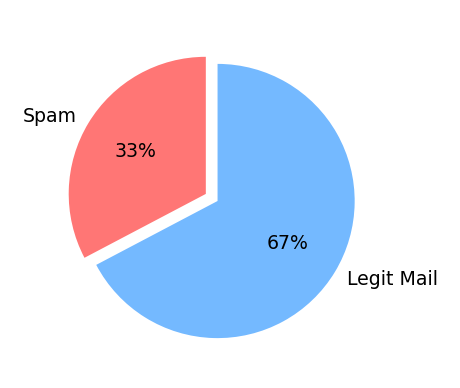

In [21]:
category_names = ['Spam', 'Legit Mail']
sizes= [amount_of_spam, amount_of_ham]
custom_colours= ['#ff7675','#74b9ff']
plt.figure( figsize= (2,2), dpi=227)
plt.pie(sizes, labels= category_names, textprops= {'fontsize':6}, startangle=90,autopct='%1.0f%%' , colors=custom_colours, explode= [0,0.1])
plt.show()

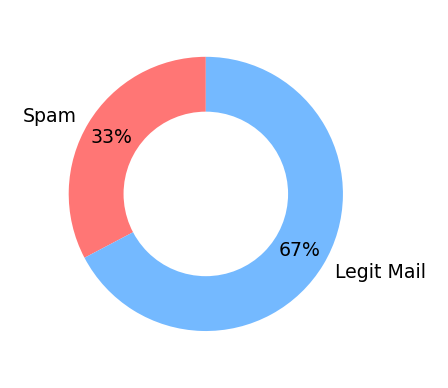

In [22]:
category_names = ['Spam', 'Legit Mail']
sizes= [amount_of_spam, amount_of_ham]
custom_colours= ['#ff7675','#74b9ff']
plt.figure( figsize= (2,2), dpi=227)
plt.pie(sizes, labels= category_names, textprops= {'fontsize':6}, startangle=90,autopct='%1.0f%%' , 
                                                    colors=custom_colours, pctdistance=0.8)

#Draw circle
centre_circle = plt.Circle((0,0), radius=0.6, fc='white')
plt.gca().add_artist(centre_circle)
plt.show()


# Natural Language Processing (NLP)
## Text Pre-Processing

In [23]:
msg = 'All work an no play makes Jack a dull boy.'
msg.lower()

'all work an no play makes jack a dull boy.'

## Download the NLTK resources (Tokenizer & Stopwordsl)

In [24]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to C:\Users\Diana C
[nltk_data]     Contreras\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [25]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to C:\Users\Diana C
[nltk_data]     Contreras\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Tokenizing

In [26]:
word_tokenize(msg.lower())

['all', 'work', 'an', 'no', 'play', 'makes', 'jack', 'a', 'dull', 'boy', '.']

In [27]:
stop_words= set(stopwords.words('english'))
if 'hello' in stop_words: print('in list')

In [44]:
msg = 'All work an no play makes Jack a dull boy. To be or not to be'
words= word_tokenize(msg.lower())
stemmer= PorterStemmer()
# stemmer= SnowballStemmer('english')
filtered_words = []
for word in words:
    if word not in stop_words and word.isalpha():
        #Stemming 
        stemmed_word= stemmer.stem(word)
        # Filtering
        filtered_words.append(stemmed_word)

print(filtered_words)

['work', 'play', 'make', 'jack', 'dull', 'boy']


In [45]:
soup = BeautifulSoup(data.at[2,'MESSAGE'], 'html.parser')
soup.get_text()

"1) Fight The Risk of Cancer!\n\nhttp://www.adclick.ws/p.cfm?o=315&s=pk007\n\n\n\n2) Slim Down - Guaranteed to lose 10-12 lbs in 30 days\n\nhttp://www.adclick.ws/p.cfm?o=249&s=pk007\n\n\n\n3) Get the Child Support You Deserve - Free Legal Advice\n\nhttp://www.adclick.ws/p.cfm?o=245&s=pk002\n\n\n\n4) Join the Web's Fastest Growing Singles Community\n\nhttp://www.adclick.ws/p.cfm?o=259&s=pk007\n\n\n\n5) Start Your Private Photo Album Online!\n\nhttp://www.adclick.ws/p.cfm?o=283&s=pk007\n\n\n\nHave a Wonderful Day,\n\nOffer Manager\n\nPrizeMama\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nIf you wish to leave this list please use the link below.\n\nhttp://www.qves.com/trim/?zzzz@spamassassin.taint.org%7C17%7C308417\n\n\n"

## Functions for Email Processing

In [46]:
def clean_msg_no_html(message, stemmer= PorterStemmer(),
                            stop_words= set(stopwords.words('english'))):
    soup = BeautifulSoup(message, 'html.parser')
    cleaned_text= soup.get_text()
    words = word_tokenize(cleaned_text.lower())
    filtered_words = []
    for word in words:
        if word not in stop_words and word.isalpha():
            filtered_words.append(stemmer.stem(word))

    return filtered_words

## Apply Cleaning and Tokeinisation to all messages

In [47]:
data.iat[2,0]
data.iloc[5:11]


,MESSAGE,CATEGORY,FILE_NAME
DOC_ID,,,
5,A POWERHOUSE GIFTING PROGRAM You Don't Want To...,1,00006.5ab5620d3d7c6c0db76234556a16f6c1
6,Help wanted. We are a 14 year old fortune 500...,1,00007.d8521faf753ff9ee989122f6816f87d7
7,<html>\n\n<head>\n\n<title>ReliaQuote - Save U...,1,00008.dfd941deb10f5eed78b1594b131c9266
8,TIRED OF THE BULL OUT THERE?\n\nWant To Stop L...,1,00009.027bf6e0b0c4ab34db3ce0ea4bf2edab
9,"Dear ricardo1 ,\n\n\n\n<html>\n\n<body>\n\n<ce...",1,00010.445affef4c70feec58f9198cfbc22997
10,Cellular Phone Accessories All At Below Wholes...,1,00011.61816b9ad167657773a427d890d0468e


In [48]:
first_emails= data.MESSAGE.iloc[0:3]
nested_list= first_emails.apply(clean_msg_no_html)

In [49]:
# flat_list = []
# for sublist in nested_list:
#     for item in sublist:
#         flat_list.append(item)
flat_list = [item for sublist in nested_list for item in sublist]
len(flat_list)

192

In [50]:
nested_list= data.MESSAGE.apply(clean_msg_no_html)

c:\Users\Diana C Contreras\anaconda3\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
c:\Users\Diana C Contreras\anaconda3\lib\site-packages\bs4\__init__.py:404: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(


In [51]:
nested_list.tail()

DOC_ID
5791    [http, bizarr, collect, stuf, anim, could, fet...
5792    [care, use, one, also, realli, cute, thing, ja...
5793    [sm, skip, montanaro, write, jeremi, put, anot...
5794    [mark, hammond, like, given, zodb, sound, attr...
5795    [hi, probabl, use, whatsoev, also, problem, re...
Name: MESSAGE, dtype: object

In [52]:
doc_ids_spam = data[data.CATEGORY ==1].index
doc_ids_ham = data[data.CATEGORY ==0].index

In [53]:
doc_ids_ham

Int64Index([1896, 1897, 1898, 1899, 1900, 1901, 1902, 1903, 1904, 1905,
            ...
            5786, 5787, 5788, 5789, 5790, 5791, 5792, 5793, 5794, 5795],
           dtype='int64', name='DOC_ID', length=3900)

In [54]:
nested_list_spam= nested_list.loc[doc_ids_spam]
nested_list_ham= nested_list.loc[doc_ids_ham]

In [55]:
flat_list_ham = [item for sublist in nested_list_ham for item in sublist]
flat_list_spam = [item for sublist in nested_list_spam for item in sublist]
normal_words = pd.Series(flat_list_ham).value_counts()
spammy_words = pd.Series(flat_list_spam).value_counts()
normal_words.shape[0] # total number of unique words in the non-spam messages


20814

In [56]:
spammy_words[:10]

http      3097
email     3090
free      2585
click     2058
receiv    1989
list      1971
get       1914
pleas     1852
busi      1792
order     1746
dtype: int64

In [57]:
spammy_words.shape[0]

13241

## Creating a Word Cloud

In [ ]:
nltk.download('gutenberg')

[nltk_data] Downloading package gutenberg to C:\Users\Diana C
[nltk_data]     Contreras\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\gutenberg.zip.


True

In [ ]:
nltk.download('shakespeare')

[nltk_data] Downloading package shakespeare to C:\Users\Diana C
[nltk_data]     Contreras\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\shakespeare.zip.


True

In [ ]:
example_corpus= nltk.corpus.gutenberg.words('melville-moby_dick.txt')
len(example_corpus)

260819

In [ ]:
word_list = [''.join(word) for word in example_corpus]
novel_as_string = ' '.join(word_list)

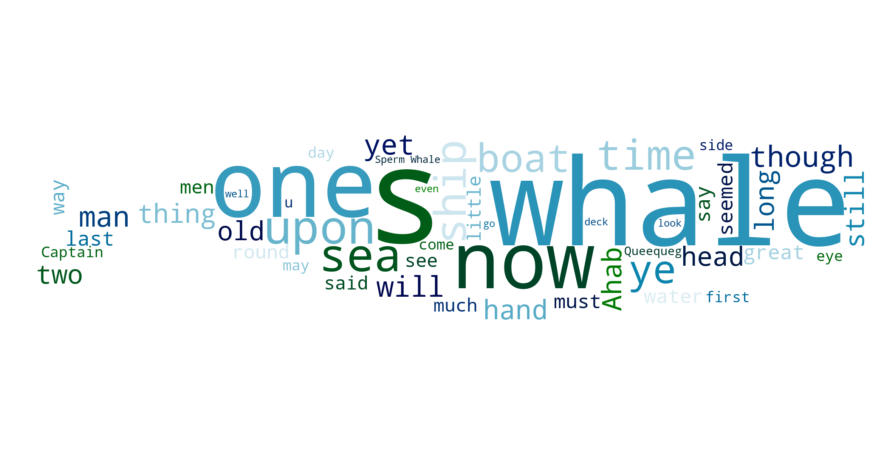

In [ ]:
icon= Image.open(WHALE_FILE)
image_mask= Image.new(mode='RGB', size= icon.size, color=(255,255,255))
image_mask.paste(icon, box= icon)
rgb_array= np.array(image_mask) # Converts the image object to an array

word_cloud= WordCloud(mask= rgb_array, background_color='white',
                        max_words=50, colormap='ocean').generate(novel_as_string)
plt.figure(figsize=(16,8))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

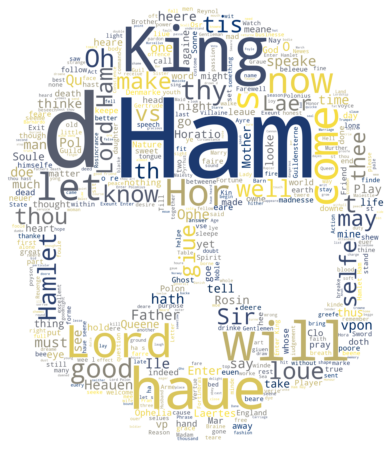

In [ ]:

example_corpus= nltk.corpus.gutenberg.words('shakespeare-hamlet.txt')
word_list = [''.join(word) for word in example_corpus]
novel_as_string = ' '.join(word_list)
icon= Image.open(SKULL_FILE)
image_mask= Image.new(mode='RGB', size= icon.size, color=(255,255,255))
image_mask.paste(icon, box= icon)
rgb_array= np.array(image_mask) # Converts the image object to an array

word_cloud= WordCloud(mask= rgb_array, background_color='white',
                        max_words=500, colormap='cividis').generate(novel_as_string)
plt.figure(figsize=(16,8))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## WordCloud of Ham and Spam Messages

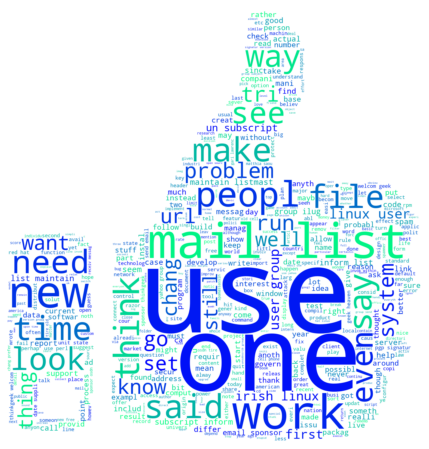

In [ ]:
icon= Image.open(THUMBS_UP_FILE)
image_mask= Image.new(mode='RGB', size= icon.size, color=(255,255,255))
image_mask.paste(icon, box= icon)
rgb_array= np.array(image_mask) # Converts the image object to an array

# Generate the text as a string for the word cloud
ham_str= ' '.join(flat_list_ham)

word_cloud= WordCloud(mask= rgb_array, background_color='white',
                        max_words=500, colormap='winter').generate(ham_str)
plt.figure(figsize=(16,8))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

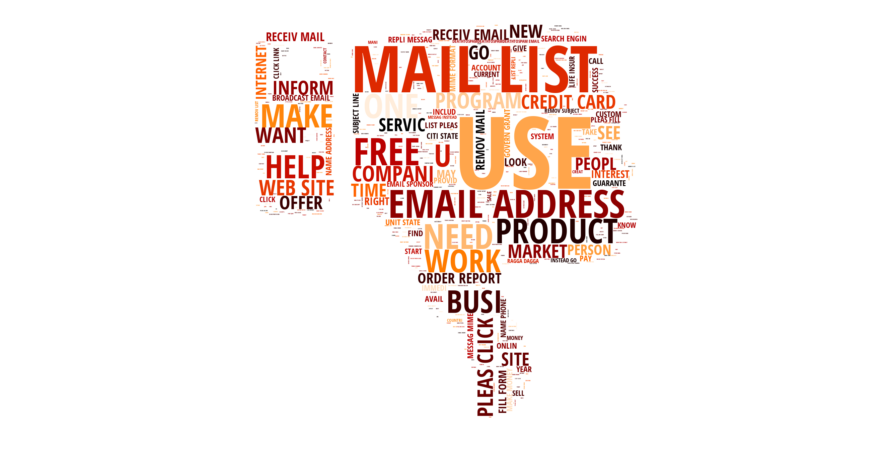

In [ ]:
icon= Image.open(THUMBS_DOWN_FILE)
image_mask= Image.new(mode='RGB', size= icon.size, color=(255,255,255))
image_mask.paste(icon, box= icon)
rgb_array= np.array(image_mask) # Converts the image object to an array

# Generate the text as a string for the word cloud
spam_str= ' '.join(flat_list_spam)

word_cloud= WordCloud(mask= rgb_array, background_color='white', max_font_size=300,
                        max_words=500, colormap='gist_heat', font_path=CUSTOM_FONT_FILE).generate(spam_str.upper())
plt.figure(figsize=(16,8))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## Generate Vocabulary & Dictionary

In [58]:
stemmed_nested_list = data.MESSAGE.apply(clean_msg_no_html)
flat_stemmed_list = [item for sublist in stemmed_nested_list for item in sublist]

c:\Users\Diana C Contreras\anaconda3\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
c:\Users\Diana C Contreras\anaconda3\lib\site-packages\bs4\__init__.py:404: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(


In [59]:
unique_words = pd.Series(flat_stemmed_list).value_counts()
print('Nr of unique words', unique_words.shape[0])

Nr of unique words 27332


In [60]:
frequent_words = unique_words[0:VOCAB_SIZE]
print('Most common words: \n', frequent_words[:10])

Most common words: 
 http     10660
use       5019
list      4851
email     4367
get       4200
mail      3983
one       3907
free      3202
time      3042
work      2883
dtype: int64


## Create Vocabulary DataFrame with a WORD_ID

In [61]:
word_ids = list(range(0, VOCAB_SIZE))
vocab= pd.DataFrame({'VOCAB_WORD': frequent_words.index.values}, index = word_ids)
vocab.index.name = 'WORD_ID'
vocab.head()

,VOCAB_WORD
WORD_ID,
0,http
1,use
2,list
3,email
4,get


## Save the Vocabulary as a CSV File

In [ ]:
vocab.to_csv(WORD_ID_FILE, index_label=vocab.index.name, header= vocab.VOCAB_WORD.name)

In [ ]:
'app' in set(vocab.VOCAB_WORD)

True

In [ ]:
clean_email_lenghts = [len(sublist) for sublist in stemmed_nested_list]
print('Nr words in the longest email:', max(clean_email_lenghts))

Nr words in the longest email: 7671


In [ ]:
print('Email position in the list (and dataframe)', np.argmax(clean_email_lenghts))

Email position in the list (and dataframe) 5775


In [ ]:
data.at[np.argmax(clean_email_lenghts), 'MESSAGE']

# Generate Features & a Sparse Matrix
### Creating a DataFrame with one Word per Column

In [ ]:
type(stemmed_nested_list.tolist())

list

In [62]:
word_columns_df= pd.DataFrame.from_records(stemmed_nested_list.tolist())
word_columns_df.head()
word_columns_df.shape

(5796, 7671)

## Splitting the Data into a Training and Testing Dataset

In [63]:
x_train, x_test, y_train, y_test = train_test_split(word_columns_df,data.CATEGORY, 
                                                    random_state=42, test_size=.30)

In [64]:
print('Nr of training samples:', x_train.shape[0])

Nr of training samples: 4057


In [65]:
x_train.index.name = x_test.index.name = 'DOC_ID'


In [67]:
x_train.head()

,0,1,2,3,4,5,6,7,8,9,...,7661,7662,7663,7664,7665,7666,7667,7668,7669,7670
DOC_ID,,,,,,,,,,,,,,,,,,,,,
4844,ye,inde,agent,directori,verita,cd,unix,subdirectori,file,call,...,None,None,None,None,None,None,None,None,None,None
4727,problem,come,tri,instal,harddissssk,like,alreadi,mount,http,yahoo,...,None,None,None,None,None,None,None,None,None,None
5022,origin,messag,date,mon,aug,chad,norwood,sven,cc,subject,...,None,None,None,None,None,None,None,None,None,None
3504,inlin,folk,sever,major,internet,outag,morn,across,major,provid,...,None,None,None,None,None,None,None,None,None,None
3921,url,http,date,bath,chronicl,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


### Create a Sparse Matrix for the Training Data

In [66]:
word_index = pd.Index(vocab.VOCAB_WORD)

In [68]:
def make_sparse_matrix(df, indexed_words, labels):
    """
    Returns sparse matrix as dataframe.
    df: A dataframe with words in the columns with a document if as an idex (Xtrain or Xtest)
    indexed_words: index of words oriented by word id
    labels: category as a series (y_train or y_test)
    """
    nr_rows = df.shape[0]
    nr_cols = df.shape[1]
    word_set = set(indexed_words)
    dict_list = []

    for i in range(nr_rows):
        for j in range(nr_cols):
            word = df.iat[i,j]
            if word in word_set:
                doc_id = df.index[i]
                word_id = indexed_words.get_loc(word)
                category = labels.at[doc_id]

                item = {'LABEL': category, 'DOC_ID': doc_id, 'OCCURENCE': 1, 'WORD_ID': word_id}
                dict_list.append(item)


    return pd.DataFrame(dict_list)

In [69]:
sparse_train_df = make_sparse_matrix(x_train, word_index, y_train)

In [70]:
sparse_train_df.shape #445842

(429184, 4)

In [71]:
sparse_train_df[-5:]

,LABEL,DOC_ID,OCCURENCE,WORD_ID
429179,1,860,1,47
429180,1,860,1,1431
429181,1,860,1,26
429182,1,860,1,21
429183,1,860,1,126


### Combine Ocuurrences with the Pandas groupby() Method

In [72]:
train_grouped = sparse_train_df.groupby(['DOC_ID', 'WORD_ID', 'LABEL']).sum()
train_grouped = train_grouped.reset_index()

In [74]:
train_grouped.tail()

,DOC_ID,WORD_ID,LABEL,OCCURENCE
258327,5795,2032,0,2
258328,5795,2037,0,1
258329,5795,2271,0,1
258330,5795,2348,0,1
258331,5795,2379,0,1


In [76]:
vocab.at[2032,'VOCAB_WORD']

'swap'

In [78]:
train_grouped.shape

(258332, 4)

### Save Training Sata as .txt File

In [79]:
np.savetxt(TRAINING_DATA_FILE, train_grouped, fmt='%d')

In [80]:
train_grouped.head()

,DOC_ID,WORD_ID,LABEL,OCCURENCE
0,0,2,1,1
1,0,3,1,2
2,0,4,1,1
3,0,7,1,3
4,0,11,1,1


In [81]:
sparse_test_df= make_sparse_matrix(x_test, word_index, y_test)

In [82]:
test_grouped= sparse_test_df.groupby(['DOC_ID', 'WORD_ID', 'LABEL']).sum().reset_index()

In [83]:
np.savetxt(TEST_DATA_FILE, test_grouped, fmt='%d')

In [86]:
test_grouped.shape

(117774, 4)